# Data Preparation

* In our test.csv we have to predict 8 months in the future
* Kaggle will release a new test.csv with future months: March, April, May 2023
* So we need to predict 3 months in the future for the main test
* But we need to predict 8 months in the current test.csv
* We could model our nn to predict the next 3 months and then merge the predictions to get 8 months
* Parameters:
    * We should test using a different number of lag features in the model and comparing the results
    * We should be able to also choose the number of months to predict

In [274]:
import pandas as pd
import numpy as np
import math

df_train = pd.read_csv('io/dataset/train.csv')
df_coords = pd.read_csv('io/customdata/cfips_coordinates.csv')

df_train.sort_values(by=['cfips', 'first_day_of_month'], inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [275]:
# Customizable Parameters

NUMBER_OF_LAGS = 3
NUMBER_OF_PREDICTIONS = 3

In [276]:
def prepare_train_data(df_train, df_coords, n_lag=7, n_predict=3, drop_months_before_predict=1):
  df_copy = df_train.copy()[['cfips', 'first_day_of_month', 'microbusiness_density']]
  cfips = df_copy['cfips'].unique()
  # predict features
  for i in range(1+drop_months_before_predict, n_predict + 1+drop_months_before_predict):
    df_copy[f'predict_{i}'] = df_copy.groupby(['cfips'])['microbusiness_density'].shift(-i)
  # lag and diff features
  for i in range(1, n_lag + 1):
    df_copy[f'lag_{i}'] = df_copy.groupby(['cfips'])['microbusiness_density'].shift(i)
    if i == 1:
      df_copy[f'diff_{i}'] = df_copy['microbusiness_density'] - df_copy[f'lag_{i}']
      df_copy[f'diffdiv_{i}'] = df_copy[f'microbusiness_density'] / df_copy[f'lag_{i}'] - 1
    else:
      df_copy[f'diff_{i}'] = df_copy[f'lag_{i-1}'] - df_copy[f'lag_{i}']
      df_copy[f'diffdiv_{i}'] = df_copy[f'diff_{i}'] / df_copy[f'lag_{i}'] - 1
    df_copy[f'diff_{i}'] = df_copy[f'diff_{i}'].abs()
    df_copy[f'diffdiv_{i}'] = df_copy[f'diffdiv_{i}'].abs()
  # latitude and longitude
  for row in df_coords.itertuples():
    if row.cfips in cfips:
        df_copy.loc[df_copy['cfips'] == row.cfips, 'latitude'] = row.lat
        df_copy.loc[df_copy['cfips'] == row.cfips, 'longitude'] = row.lon
  # dropna
  df_copy.dropna(inplace=True)
  df_copy.reset_index(drop=True, inplace=True)
  df_predict_columns = [col for col in df_copy if col.startswith('predict')]
  df_predict = df_copy[df_predict_columns]
  df_copy.drop(df_predict_columns, axis=1, inplace=True)
  return df_copy, df_predict

In [277]:
df_prepared, df_prepared_predict = prepare_train_data(
  df_train,
  df_coords,
  n_lag=NUMBER_OF_LAGS,
  n_predict=NUMBER_OF_PREDICTIONS,
)

In [278]:
# list features
# The first item should look like this:
#           mbd       lag_1     diff_1   lag_2    diff_2    lag_3    diff_3
#           2,993233  3,055843 -0,06261 2,88487 0,170973 3,007682 -0,122812
df_prepared.tail()

,cfips,first_day_of_month,microbusiness_density,lag_1,diff_1,diffdiv_1,lag_2,diff_2,diffdiv_2,lag_3,diff_3,diffdiv_3,latitude,longitude
100292,56045,2022-02-01,1.749688,1.749688,0.000000,0.000000,1.796300,0.046612,1.025949,1.760374,0.035926,0.979592,43.77916,-104.235812
100293,56045,2022-03-01,1.767542,1.749688,0.017854,0.010204,1.749688,0.000000,1.000000,1.796300,0.046612,1.025949,43.77916,-104.235812
100294,56045,2022-04-01,1.767542,1.767542,0.000000,0.000000,1.749688,0.017854,0.989796,1.749688,0.000000,1.000000,43.77916,-104.235812
100295,56045,2022-05-01,1.803249,1.767542,0.035708,0.020202,1.767542,0.000000,1.000000,1.749688,0.017854,0.989796,43.77916,-104.235812
100296,56045,2022-06-01,1.803249,1.803249,0.000000,0.000000,1.767542,0.035708,0.979798,1.767542,0.000000,1.000000,43.77916,-104.235812


In [279]:
df_prepared_predict.tail()

,predict_2,predict_3,predict_4
100292,1.767542,1.803249,1.803249
100293,1.803249,1.803249,1.803249
100294,1.803249,1.803249,1.785395
100295,1.803249,1.785395,1.785395
100296,1.785395,1.785395,1.785395


<AxesSubplot: xlabel='first_day_of_month'>

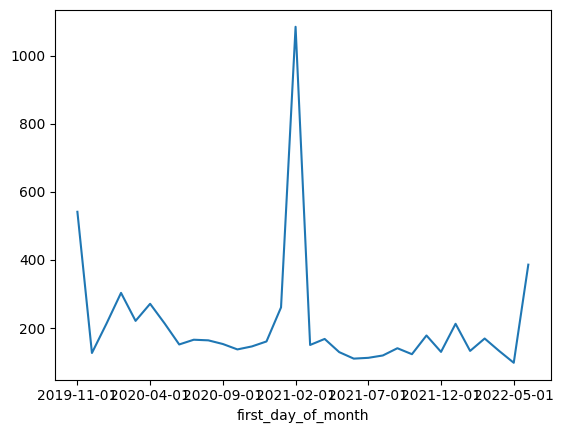

In [280]:
# TEST
df_prepared.groupby('first_day_of_month')['diff_1'].sum().plot()

<AxesSubplot: xlabel='first_day_of_month'>

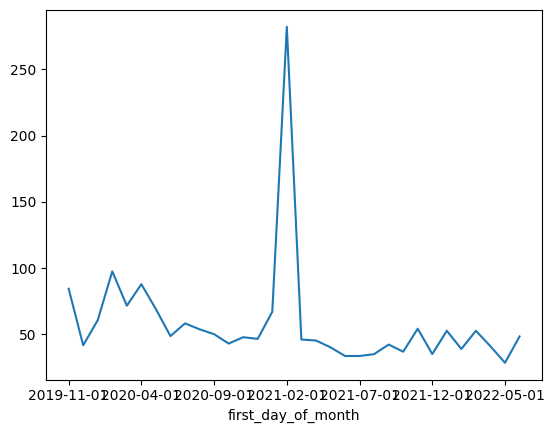

In [281]:
# TEST
df_prepared.groupby('first_day_of_month')['diffdiv_1'].sum().plot()

<AxesSubplot: xlabel='first_day_of_month'>

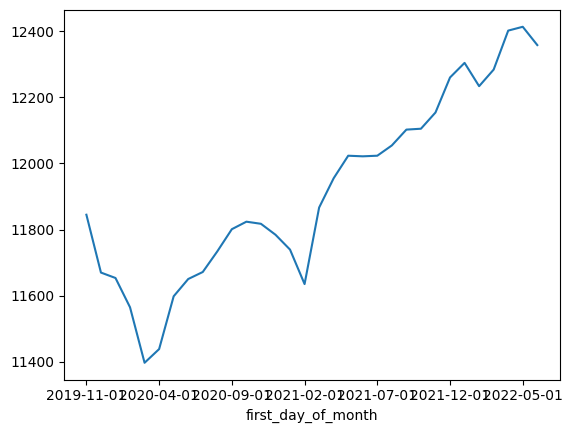

In [282]:
# TEST
df_prepared.groupby('first_day_of_month')['lag_1'].sum().plot()